In [1]:
!pip install tslearn

     |████████████████████████████████| 770 kB 16.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 58.9 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 74.8 MB/s eta 0:00:01


In [2]:
!pip install iisignature

     |████████████████████████████████| 1.3 MB 14.2 MB/s eta 0:00:01
  Created wheel for iisignature: filename=iisignature-0.24-cp36-cp36m-linux_x86_64.whl size=2522994 sha256=33e7841501b9573f81fe4549c0a1afa2eb9f543e5c5372fd7426fc85917572ad
  Stored in directory: /home/azureuser/.cache/pip/wheels/4d/1d/7d/44bbe495b4af0c25baacc704f8b26e5def26268ce749688f0a
Successfully built iisignature


In [3]:
# !git clone 'https://github.com/crispitagorico/Signature-Kernel.git'

# %cd Signature-Kernel/src/ 

# !python setup.py build_ext --inplace

In [1]:
%cd Signature-Kernel/notebooks/

/mnt/batch/tasks/shared/LS_root/mounts/clusters/m32-256-cs/code/Users/csalvi/Signature-Kernel/notebooks


In [2]:
import base

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import notebook as tqdm
import matplotlib.pyplot as plt
import torch 

import iisignature

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from tslearn.svm import TimeSeriesSVC

from transformers_sig import AddTime, LeadLag

from sigKer_fast import sig_kernel_Gram_matrix 
# from sigKer_torch import SigKernelGramMat

In [3]:
def transform(paths, scale=1., at=False, ll=False):
    paths = scale*paths
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
    return np.array(paths)

In [4]:
data = UCR_UEA_datasets().list_multivariate_datasets()

# 14:'Heartbeat', 
# 19:'MotorImagery', 
# 20:'NATOPS', 
# 22:'PEMS-SF'

In [4829]:
name = data[26]
print(name)

SelfRegulationSCP2


In [4830]:
X_train, Y_train, X_test, Y_test = UCR_UEA_datasets(use_cache=True).load_dataset(name)

In [5197]:
subsample = 1
subsample_len = 20

x_train = X_train[::subsample,::subsample_len,:]
y_train = Y_train[::subsample]
x_test = X_test[::subsample,::subsample_len,:]
y_test = Y_test[::subsample]

# x_train = TimeSeriesScalerMinMax().fit_transform(x_train)
# x_train = TimeSeriesScalerMeanVariance().fit_transform(x_train)
# x_test = TimeSeriesScalerMinMax().fit_transform(x_test)
# x_test = TimeSeriesScalerMeanVariance().fit_transform(x_test)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

print(x_train.shape)
print(x_test.shape)

(200, 58, 7)
(180, 58, 7)


In [5198]:
scale = 1e-1
at = True
ll = False

x_train = transform(x_train, scale, at, ll)
x_test = transform(x_test, scale, at, ll)

0


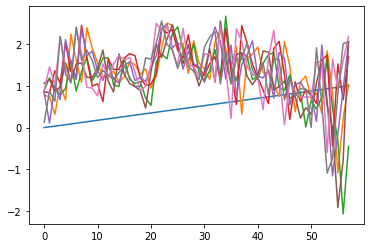

In [5199]:
k=6
plt.plot(x_train[k])
print(y_train[k])
plt.show()

In [5200]:
print(f'classes: {np.unique(y_train)}')

classes: [0 1]


In [5201]:
n,solver =  0,0

In [5202]:
# x_train_ = torch.tensor(x_train).cuda()
# x_test_ = torch.tensor(x_test).cuda()

In [5203]:
rbf, sigma = True, 1e2

In [5204]:
gram_matrix = sig_kernel_Gram_matrix(x_train, x_train, n, solver, sym=True, rbf=rbf, sigma=sigma)
# gram_matrix_ = SigKernelGramMat.apply(x_train_, x_train_, n, solver, True)

In [5205]:
test_matrix = sig_kernel_Gram_matrix(x_train, x_test, n, solver, sym=False, rbf=rbf, sigma=sigma)
# test_matrix_ = SigKernelGramMat.apply(x_train_, x_test_, n, solver, False)

In [5206]:
# gram_matrix = gram_matrix_.cpu().numpy()
# test_matrix = test_matrix_.cpu().numpy()

In [5207]:
# np.nan_to_num(test_matrix,copy=False,nan=50.)

In [5208]:
gram_matrix

array([[19.56966728,  1.37113348,  1.15027048, ...,  1.32213724,
         2.12495856,  1.40824837],
       [ 1.37113348,  6.71479461,  3.08263596, ...,  4.21369413,
         2.31064949,  3.07845606],
       [ 1.15027048,  3.08263596,  6.51764129, ...,  2.93257981,
         1.36150899,  2.06704254],
       ...,
       [ 1.32213724,  4.21369413,  2.93257981, ...,  4.9137125 ,
         1.94558318,  2.77814136],
       [ 2.12495856,  2.31064949,  1.36150899, ...,  1.94558318,
         3.50442097,  1.6471054 ],
       [ 1.40824837,  3.07845606,  2.06704254, ...,  2.77814136,
         1.6471054 ,  5.32399673]])

In [5209]:
svc_parameters = {'C': np.logspace(0, 5, 6), 'gamma': np.logspace(-5, 5, 11)}
# svc_parameters = {'C': np.logspace(0, 4, 5), 'gamma': np.logspace(-2, 2, 5)}

In [5210]:
svc = TimeSeriesSVC(kernel='precomputed', decision_function_shape='ovo')

svc_model = GridSearchCV(estimator=svc, 
                         param_grid=svc_parameters, 
                         cv=TimeSeriesSplit(n_splits=2),
                         n_jobs=-1)

In [5211]:
svc_model.fit(gram_matrix, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score=nan,
             estimator=TimeSeriesSVC(C=1.0, cache_size=200, class_weight=None,
                                     coef0=0.0, decision_function_shape='ovo',
                                     degree=3, gamma='auto',
                                     kernel='precomputed', max_iter=-1,
                                     n_jobs=None, probability=False,
                                     random_state=None, shrinking=True,
                                     tol=0.001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
                         'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [5212]:
predictions = svc_model.predict(test_matrix.T)

In [5213]:
svc_model.score(test_matrix.T, y_test)

0.6

In [5214]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        90
           1       0.60      0.60      0.60        90

    accuracy                           0.60       180
   macro avg       0.60      0.60      0.60       180
weighted avg       0.60      0.60      0.60       180



In [5215]:
confusion_matrix(predictions, y_test)

array([[54, 36],
       [36, 54]])

In [5216]:
final = {}

In [5217]:
final['sig-ker-PDE'] = svc_model.score(test_matrix.T, y_test)

In [5218]:
for ker in tqdm.tqdm(['linear', 'rbf']):
    
    svc = TimeSeriesSVC(kernel=ker, gamma='auto', decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)
    
    svc_model.fit(x_train, y_train)
    
    final[ker] = svc_model.score(x_test, y_test)

In [5221]:
for gamma in tqdm.tqdm([1., 0.1, 0.01, 0.001]):
            
    svc = TimeSeriesSVC(kernel='gak', gamma=gamma, decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)

    svc_model.fit(x_train, y_train)

    final[f'gak_{gamma}'] = svc_model.score(x_test, y_test)

In [5219]:
### truncated signature kernel
for d in tqdm.tqdm(range(1,4)):
    
    svc = TimeSeriesSVC(kernel='linear', decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)

    sig_train = iisignature.sig(x_train, d)
    sig_test = iisignature.sig(x_test, d)

    svc_model.fit(sig_train, y_train)

    final[f'sig-ker-{d}'] = svc_model.score(sig_test, y_test)

KeyboardInterrupt: 

In [5220]:
final

{'sig-ker-PDE': 0.6,
 'linear': 0.4222222222222222,
 'rbf': 0.4666666666666667,
 'sig-ker-1': 0.5277777777777778}

In [4631]:
final_csv = pd.DataFrame.from_dict(final, orient='index').rename(columns={0:'accuracy (%)'})
print(final_csv)
if rbf:
    if ll:
        if at:
            final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}-{np.round(sigma,1)}-LL-AT.csv')
        else:
            final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}-{np.round(sigma,1)}-LL.csv')
    else:
        if at:
            final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}-{np.round(sigma,1)}-AT.csv')
        else:
            final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}-{np.round(sigma,1)}.csv')
else:
    if ll:
        if at:
            final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}-LL-AT.csv')
        else:
            final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}-LL.csv')
    else:
        if at:
            final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}-AT.csv')
        else:
            final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}.csv')

             accuracy (%)
sig-ker-PDE      0.903125
linear           0.793750
rbf              0.840625
gak_1.0          0.890625
gak_0.1          0.890625
gak_0.01         0.890625
gak_0.001        0.890625
sig-ker-1        0.462500
sig-ker-2        0.793750
sig-ker-3        0.734375
